# Introduction

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segyio

sys.path.insert(0, '..')
import segfast

sys.path.insert(0, '../../seismiqb')
from seismiqb import Geometry

In [2]:
path = 'data/A.sgy'
size = os.path.getsize(path) / (1024 ** 3)
print(f'Input SEG-Y file size: {size:3.2f} GB')

idx = 100
timings = {}

Input SEG-Y file size: 21.00 GB


In [3]:
def plot_chart(dct, unit='ms', title='', xlabel='', color='salmon', figsize=(12, 4), ax=None, savepath=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = None

    for item in dct.values():
        ax.axhline(y=item, linewidth=0.2, color='b', linestyle='--')

    bars = ax.bar(dct.keys(), dct.values(), color=color)
    slowest = max([rect.get_height() for rect in bars])

    for rect in bars:
        height = round(rect.get_height(), 2)
        speedup = round(slowest / height, 2)
        
        ax.annotate(f'{height} {unit}\n{speedup}X',
                    xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                    xytext=(0, 0), fontsize=14,
                    textcoords="offset points", ha='center', va='bottom')

    ax.set_title(title, fontsize=22)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)

    if savepath is not None:
        fig.savefig(savepath, dpi=100, facecolor='white')
    if fig is not None:
        fig.show()

# Open handlers to SEG-Y

In [4]:
# segyio: used for testing
segyio_file = segyio.open(path, strict=True, ignore_geometry=False)
n_ilines, n_xlines = len(segyio_file.ilines), len(segyio_file.xlines)

# segfast
segfast_file = segfast.open(path=path)
segfast_file_ = segfast.open(path=path, engine='segyio')
segfast_file_q = segfast.open(path=path.replace('.sgy', '_QUANTIZED.sgy'))

# seismiqb: interpretation-only
seismiqb_file = Geometry.new(path)

# Headers

In [5]:
requested_headers = ['INLINE_3D', 'CROSSLINE_3D']
timings['headers'] = {}

In [6]:
%%time
start = perf_counter()
headers_segyio = pd.DataFrame({header : segyio_file.attributes(getattr(segyio.TraceField, header))
                               for header in requested_headers})
timings['headers']['segyio'] = perf_counter() - start

headers_segyio.head()

CPU times: user 2.73 s, sys: 7.07 s, total: 9.79 s
Wall time: 9.76 s


,INLINE_3D,CROSSLINE_3D
0,24,19
1,24,20
2,24,21
3,24,22
4,24,23


In [7]:
%%time
start = perf_counter()
headers_segfast = segfast_file.load_headers(requested_headers)
timings['headers']['segfast'] = perf_counter() - start

headers_segfast.head()

CPU times: user 101 ms, sys: 98 ms, total: 199 ms
Wall time: 519 ms


,INLINE_3D,CROSSLINE_3D,TRACE_SEQUENCE_FILE
0,24,19,1
1,24,20,2
2,24,21,3
3,24,22,4
4,24,23,5


Loaded equal headers: True


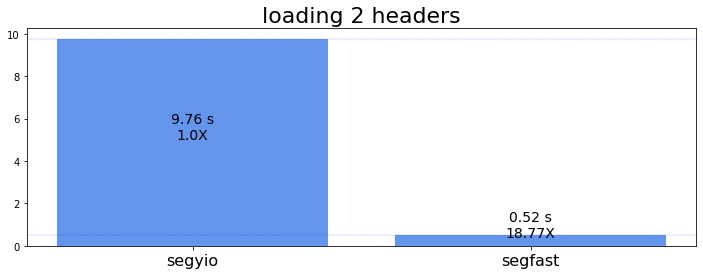

In [8]:
flag = (headers_segfast[requested_headers] == headers_segyio[requested_headers]).all().all()
print('Loaded equal headers:', flag)

plot_chart(timings['headers'], unit='s', title='loading 2 headers', color='cornflowerblue',
           savepath='timings_headers.png')

# Array export

In [9]:
%%time
array = seismiqb_file[:, :, :]
timings['export'] = {}
array.shape, array.nbytes / (1024 ** 3)

CPU times: user 7.81 s, sys: 8 s, total: 15.8 s
Wall time: 15.8 s


((2563, 1409, 1501), 20.192979898303747)

In [10]:
%%time
from shutil import copyfile
from segfast.utils import Notifier
path_out = path.replace('.sgy', '_TESTCOPY_SEGYIO.sgy')

start = perf_counter()
copyfile(path, path_out)

with segyio.open(path_out, "r+") as dst:
    for i, inline in Notifier('t')(enumerate(dst.ilines)):
        dst.iline[inline] = array[i, :, :]
        
timings['export']['segyio'] = perf_counter() - start

2563it [00:24, 103.32it/s]
CPU times: user 9.62 s, sys: 37.9 s, total: 47.6 s
Wall time: 1min 16s


In [11]:
%%time
path_out = path.replace('.sgy', '_TESTCOPY_SEISMIQB.sgy')

start = perf_counter()
seismiqb_file.export_array(array, path_out)
timings['export']['seismiqb'] = perf_counter() - start

Writing `A_TESTCOPY_SEISMIQB.sgy`: 100%|███| 2563/2563 [00:13<00:00, 189.33it/s]
CPU times: user 6.68 s, sys: 42.8 s, total: 49.5 s
Wall time: 16.2 s


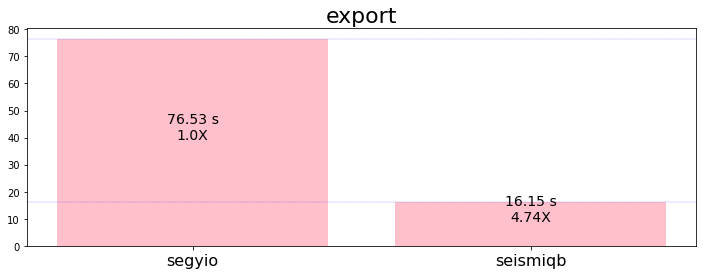

In [12]:
plot_chart(timings['export'], unit='s', title='export', color='pink', savepath='timings_export.png')

# Data loading

## inline orientation

In [13]:
def load_slide_i_segyio(segyio_file, idx):
    idx_ = segyio_file.ilines[idx]
    return segyio_file.iline[idx_]

def load_slide_i_segfast(segfast_file, idx, n_xlines):
    start = idx * n_xlines
    stop = start + n_xlines
    indices = range(start, stop)

    return segfast_file.load_traces(indices=indices)

slide_segyio_i = load_slide_i_segyio(segyio_file, idx)
slide_segfast_i = load_slide_i_segfast(segfast_file, idx, n_xlines)
slide_seismiqb_i = seismiqb_file.load_slide(idx, axis=0)

np.allclose(slide_segyio_i, slide_segfast_i), np.allclose(slide_segyio_i, slide_seismiqb_i)

(True, True)

In [14]:
timings['slide_i'] = {}

print('SEGYIO slide_i loading timings:')
timings['slide_i']['segyio'] = %timeit -n 100 -r 10 -o load_slide_i_segyio(segyio_file, idx)

print('\nSEGFAST slide_i loading timings:')
timings['slide_i']['segfast'] = %timeit -n 100 -r 10 -o load_slide_i_segfast(segfast_file, idx, n_xlines)

print('\nSEGFAST with segyio engine slide_i loading timings:')
timings['slide_i']['segfast\nsegyio engine'] = %timeit -n 100 -r 10 -o load_slide_i_segfast(segfast_file_, idx, n_xlines)

print('\nSEISMIQB slide_i loading timings:')
timings['slide_i']['seismiqb'] = %timeit -n 100 -r 10 -o seismiqb_file.load_slide(idx, axis=0)

print('\nSEGFAST quantized slide_i loading timings:')
timings['slide_i']['segfast\nquantized'] = %timeit -n 100 -r 10 -o load_slide_i_segfast(segfast_file_q, idx, n_xlines)

SEGYIO slide_i loading timings:
2.76 ms ± 151 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEGFAST slide_i loading timings:
2.33 ms ± 19 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEGFAST with segyio engine slide_i loading timings:
2.76 ms ± 228 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEISMIQB slide_i loading timings:
2.35 ms ± 89.2 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEGFAST quantized slide_i loading timings:
257 µs ± 3.23 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


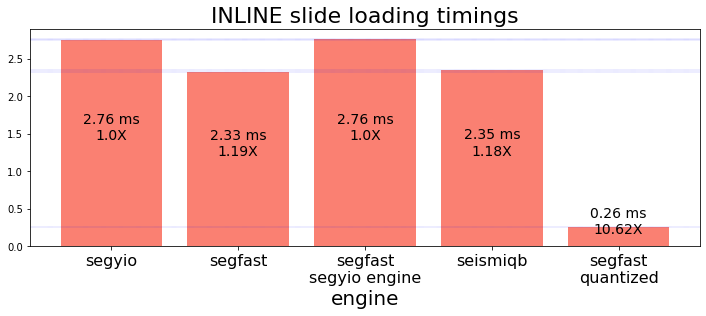

In [15]:
slide_i_timings = {key : value.average * 1000 for key, value in timings['slide_i'].items()}

plot_chart(slide_i_timings, unit='ms', title='INLINE slide loading timings', xlabel='engine', color='salmon')

## crossline orientation

In [16]:
def load_slide_x_segyio(segyio_file, idx):
    idx_ = segyio_file.xlines[idx]
    return segyio_file.xline[idx_]

def load_slide_x_segfast(segfast_file, idx, n_ilines, n_xlines):
    start = idx
    stop = start + n_xlines
    indices = range(idx, idx + n_ilines * n_xlines, n_xlines)

    return segfast_file.load_traces(indices=indices)


slide_segyio_x = load_slide_x_segyio(segyio_file, idx)
slide_segfast_x = load_slide_x_segfast(segfast_file, idx, n_ilines, n_xlines)
slide_seismiqb_x = seismiqb_file.load_slide(idx, axis=1)

np.allclose(slide_segyio_x, slide_segfast_x), np.allclose(slide_segyio_x, slide_seismiqb_x)

(True, True)

In [17]:
timings['slide_x'] = {}

print('SEGYIO slide_x loading timings:')
timings['slide_x']['segyio'] = %timeit -n 100 -r 10 -o load_slide_x_segyio(segyio_file, idx)

print('\nSEGFAST slide_x loading timings:')
timings['slide_x']['segfast'] = %timeit -n 100 -r 10 -o load_slide_x_segfast(segfast_file, idx, n_ilines, n_xlines)

print('\nSEGFAST with segyio engine slide_x loading timings:')
timings['slide_x']['segfast\nsegyio engine'] = %timeit -n 100 -r 10 -o load_slide_x_segfast(segfast_file_, idx, n_ilines, n_xlines)

print('\nSEISMIQB slide_x loading timings:')
timings['slide_x']['seismiqb'] = %timeit -n 100 -r 10 -o seismiqb_file.load_slide(idx, axis=1)

print('\nSEGFAST quantized slide_x loading timings:')
timings['slide_x']['segfast\nquantized'] = %timeit -n 100 -r 10 -o load_slide_x_segfast(segfast_file_q, idx, n_ilines, n_xlines)

SEGYIO slide_x loading timings:
9.06 ms ± 192 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEGFAST slide_x loading timings:
5 ms ± 33.5 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEGFAST with segyio engine slide_x loading timings:
5.38 ms ± 109 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEISMIQB slide_x loading timings:
5.16 ms ± 63 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

SEGFAST quantized slide_x loading timings:
550 µs ± 40 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


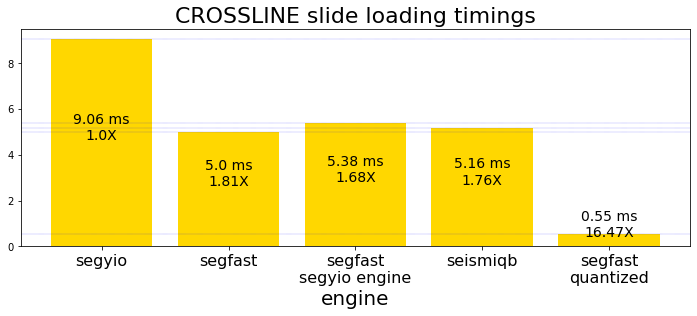

In [18]:
slide_x_timings = {key : value.average * 1000 for key, value in timings['slide_x'].items()}

plot_chart(slide_x_timings, unit='ms', title='CROSSLINE slide loading timings', xlabel='engine', color='gold')

## depth orientation

In [19]:
slide_segyio_d = segyio_file.depth_slice[idx]
slide_segfast_d = segfast_file.load_depth_slices([idx]).reshape(n_ilines, n_xlines)
slide_seismiqb_d = seismiqb_file.load_slide(idx, axis=2)

np.allclose(slide_segyio_d, slide_segfast_d), np.allclose(slide_segyio_d, slide_seismiqb_d)

(True, True)

In [20]:
timings['slide_d'] = {}

print('SEGYIO slide_d loading timings:')
timings['slide_d']['segyio'] = %timeit -o segyio_file.depth_slice[idx]

print('\nSEGFAST slide_d loading timings:')
timings['slide_d']['segfast'] = %timeit -o segfast_file.load_depth_slices([idx]).reshape(n_ilines, n_xlines)

print('\nSEGFAST with segyio engine slide_d loading timings:')
timings['slide_d']['segfast\nsegyio engine'] = %timeit -o segfast_file_.load_depth_slices([idx]).reshape(n_ilines, n_xlines)

print('\nSEISMIQB slide_d loading timings:')
timings['slide_d']['seismiqb'] = %timeit -o seismiqb_file.load_slide(idx, axis=2)

print('\nSEGFAST quantized slide_d loading timings:')
timings['slide_d']['segfast\nquantized'] = %timeit -o segfast_file_q.load_depth_slices([idx]).reshape(n_ilines, n_xlines)

SEGYIO slide_d loading timings:
3.79 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEGFAST slide_d loading timings:
62.2 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

SEGFAST with segyio engine slide_d loading timings:
289 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEISMIQB slide_d loading timings:
63.5 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

SEGFAST quantized slide_d loading timings:
54.4 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


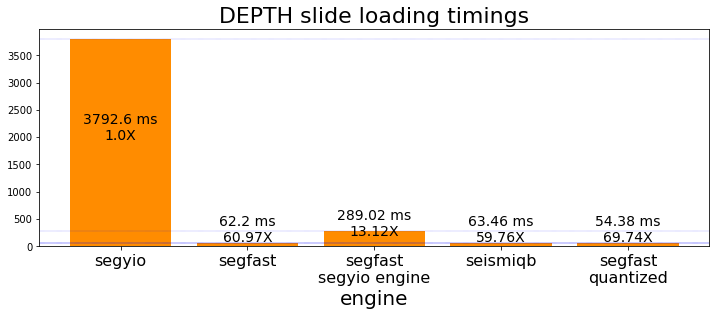

In [21]:
slide_d_timings = {key : value.average * 1000 for key, value in timings['slide_d'].items()}

plot_chart(slide_d_timings, unit='ms', title='DEPTH slide loading timings', xlabel='engine', color='darkorange')

## 3d sub-volumes

In [22]:
s = 256
limits = (200, 700)

indices = seismiqb_file.index_matrix[idx:idx+s, idx:idx+s]

In [23]:
def load_crop_segyio(segyio_file, indices, limits):
    data = [segyio_file.trace.raw[index][limits[0]:limits[1]] for index in indices.reshape(-1)]
    data = np.stack(data).reshape(*indices.shape, -1)
    return data

def load_crop_segyio2(segyio_file, indices, limits):
    data = np.empty((*indices.shape, limits[1] - limits[0]), dtype=np.float32)
    limits_slice = slice(*limits)

    for (i, j), index in np.ndenumerate(indices):
        data[i, j, :] = segyio_file.trace.raw[index][limits_slice]
    return data

def load_crop_segfast(segfast_file, indices, limits):
    data = segfast_file.load_traces(indices.reshape(-1), limits=limits)
    data = data.reshape(*indices.shape, -1)
    return data

def load_crop_seismiqb(seismiqb_file, indices, limits):
    locations = [slice(idx, idx+s), slice(idx, idx+s), slice(*limits)]
    data = seismiqb_file.load_crop(locations)
    return data

data_segyio_1 = load_crop_segyio(segyio_file, indices, limits)
data_segyio_2 = load_crop_segyio2(segyio_file, indices, limits)
data_segfast = load_crop_segfast(segfast_file, indices, limits)
data_segfast_ = load_crop_segfast(segfast_file_, indices, limits)
data_seismiqb = load_crop_seismiqb(seismiqb_file, indices, limits)

flag = all(np.allclose(data, data_segyio_1)
           for data in [data_segyio_2, data_segfast, data_segfast_, data_seismiqb])
print('All arrays are equal:', flag)

All arrays are equal: True


In [24]:
timings['crop'] = {}

print('SEGYIO crop loading timings:')
timings['crop']['segyio'] = %timeit -o load_crop_segyio(segyio_file, indices, limits)

print('\nSEGYIO with bufferization crop loading timings:')
timings['crop']['segyio2'] = %timeit -o load_crop_segyio2(segyio_file, indices, limits)

print('\nSEGFAST crop loading timings:')
timings['crop']['segfast'] = %timeit -o load_crop_segfast(segfast_file, indices, limits)

print('\nSEGFAST with segyio engine crop loading timings:')
timings['crop']['segfast\nsegyio engine'] = %timeit -o load_crop_segfast(segfast_file_, indices, limits)

print('\nSEISMIQB crop loading timings:')
timings['crop']['seismiqb'] = %timeit -o load_crop_seismiqb(seismiqb_file, indices, limits)

print('\nSEGFAST quantized crop loading timings:')
timings['crop']['segfast\nquantized'] = %timeit -o load_crop_segfast(segfast_file_q, indices, limits)

SEGYIO crop loading timings:
867 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEGYIO with bufferization crop loading timings:
677 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEGFAST crop loading timings:
79 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SEGFAST with segyio engine crop loading timings:
95.8 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SEISMIQB crop loading timings:
126 ms ± 917 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

SEGFAST quantized crop loading timings:
8.88 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


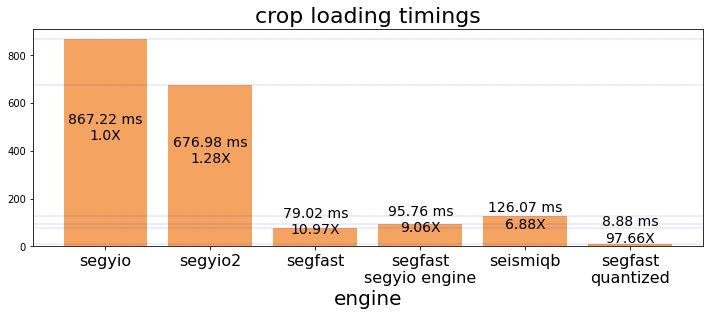

In [25]:
crop_timings = {key : value.average * 1000 for key, value in timings['crop'].items()}

plot_chart(crop_timings, unit='ms', title='crop loading timings', xlabel='engine', color='sandybrown')

## Batch of 3d patches

In [26]:
def load_segyio(segyio_file, indices, limits, n):
    data = np.empty((n, *indices.shape, limits[1] - limits[0]), dtype=np.float32)
    limits_slice = slice(*limits)

    for n_ in range(n):
        for (i, j), index in np.ndenumerate(indices):
            data[n_, i, j, :] = segyio_file.trace.raw[index][limits_slice]
    return data


def load_segfast(segfast_file, indices, limits, n):
    data = np.empty((n, *indices.shape, limits[1] - limits[0]), dtype=segfast_file.dtype)
    
    for n_ in range(n):
        segfast_file.load_traces(indices.reshape(-1), limits=limits, buffer=data[n_].reshape(indices.size, -1))
    return data.astype(np.float32)


def load_seismiqb(seismiqb_file, indices, limits, n):
    data = np.empty((n, *indices.shape, limits[1] - limits[0]), dtype=seismiqb_file.dtype)
    locations = [slice(idx, idx+s), slice(idx, idx+s), slice(*limits)]

    for n_ in range(n):
        seismiqb_file.load_crop(locations, buffer=data[n_].reshape(indices.size, -1))
    return data.astype(np.float32)

n = 10
data_segyio = load_segyio(segyio_file, indices, limits, n)
data_segfast = load_segfast(segfast_file, indices, limits, n)
data_segfast_ = load_segfast(segfast_file_, indices, limits, n)
data_seismiqb = load_seismiqb(seismiqb_file, indices, limits, n)

flag = all(np.allclose(data, data_segyio)
           for data in [data_segfast, data_segfast_, data_seismiqb])
print('All arrays are equal:', flag)

All arrays are equal: True


In [27]:
n = 20
timings['batch'] = {}

print('SEGYIO batch loading timings:')
timings['batch']['segyio'] = %timeit -o load_segyio(segyio_file, indices, limits, n)

print('\nSEGFAST batch loading timings:')
timings['batch']['segfast'] = %timeit -o load_segfast(segfast_file, indices, limits, n)

print('\nSEGFAST with segyio engine batch loading timings:')
timings['batch']['segfast\nsegyio engine'] = %timeit -o load_segfast(segfast_file_, indices, limits, n)

print('\nSEISMIQB batch loading timings:')
timings['batch']['seismiqb'] = %timeit -o load_seismiqb(seismiqb_file, indices, limits, n)

print('\nSEGFAST quantized batch loading timings:')
timings['batch']['segfast\nquantized'] = %timeit -o load_segfast(segfast_file_q, indices, limits, n)

SEGYIO batch loading timings:
14 s ± 55.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEGFAST batch loading timings:
2.53 s ± 7.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEGFAST with segyio engine batch loading timings:
3.27 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEISMIQB batch loading timings:
2.55 s ± 7.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

SEGFAST quantized batch loading timings:
1 s ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


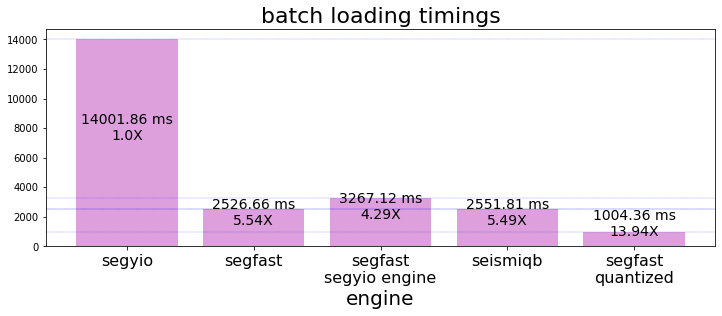

In [28]:
batch_timings = {key : value.average * 1000 for key, value in timings['batch'].items()}

plot_chart(batch_timings, unit='ms', title='batch loading timings', xlabel='engine', color='plum')

## Visualize loading timings

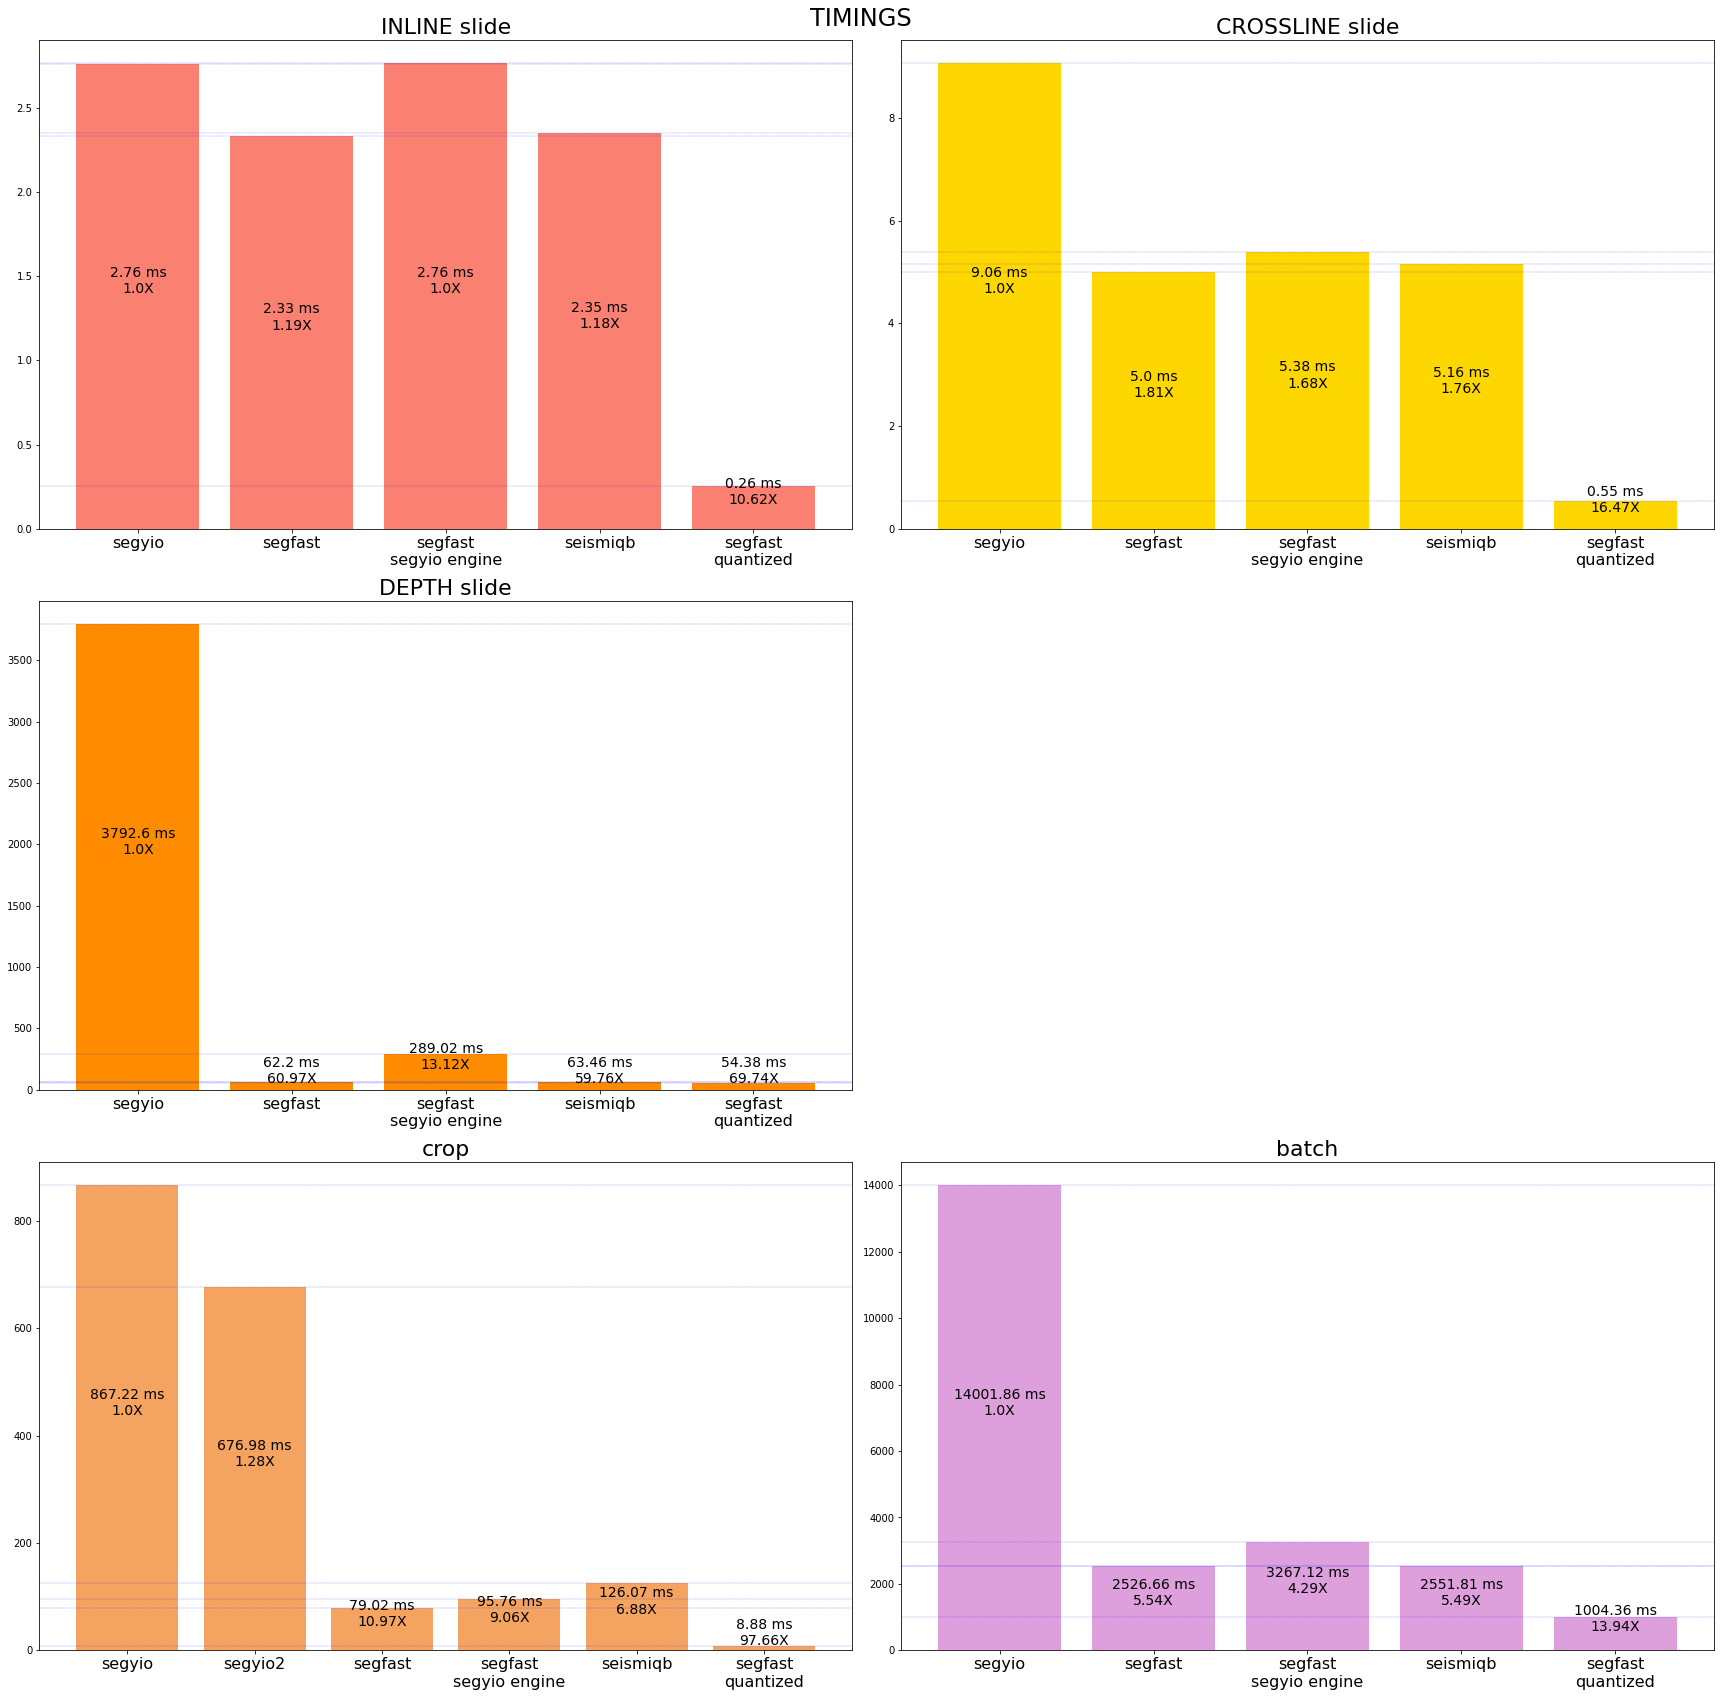

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(24, 6*4))
ax = ax.flatten()

plot_chart(slide_i_timings, unit='ms', title='INLINE slide', color='salmon', ax=ax[0])
plot_chart(slide_x_timings, unit='ms', title='CROSSLINE slide', color='gold', ax=ax[1])

plot_chart(slide_d_timings, unit='ms', title='DEPTH slide', color='darkorange', ax=ax[2])
ax[3].set_visible(False)

plot_chart(crop_timings, unit='ms', title='crop', color='sandybrown', ax=ax[4])
plot_chart(batch_timings, unit='ms', title='batch', color='plum', ax=ax[5])

fig.suptitle('TIMINGS', fontsize=24, y=0.98)
fig.tight_layout()
fig.savefig('timings_load.png', dpi=100, facecolor='white')
fig.show()